# Randomized Maximum Likelihood Solver

## Setup

### Packages

In [1]:
import warnings
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pastas as ps

from pastas_plugins.pest.solver import RandomizedMaximumLikelihoodSolver

warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'
/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Data

In [2]:
df = ps.load_dataset("collenteur_2021")["wagna"]
head = df["head [m]"].dropna().rename("head")
evap = df["evaporation [mm/d]"].rename("evaporation").dropna()
prec = df["precipitation [mm/d]"].rename("precipitation").loc[evap.index]

### Constants

In [3]:
constant_d = 5.0
rch_A = 0.5
rch_n = 1.1
rch_a = 250.0
rch_f = -0.8
tmin = pd.Timestamp("1980-01-01")
tmax = pd.Timestamp("2019-12-31")

noise_std = 0.025

### Helper functions

Model is not optimized yet, initial parameters are used.


<Axes: >

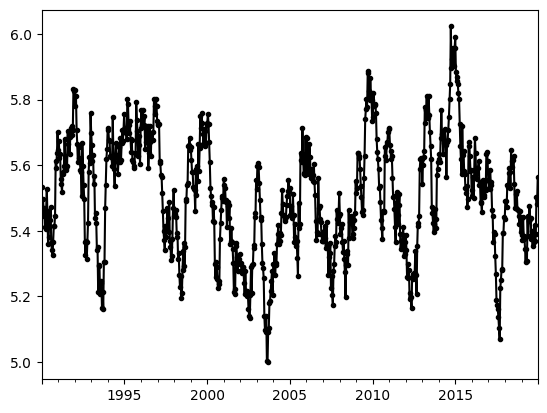

In [4]:
def get_model(obs: pd.Series) -> ps.Model:
    ml = ps.Model(obs, name="synthetic_model")
    sms = []
    rm = ps.RechargeModel(
        prec=prec,
        evap=evap,
        rfunc=ps.Gamma(),
        name="rch",
    )
    sms.append(rm)
    ml.add_stressmodel(sms)
    ml.add_noisemodel(ps.ArNoiseModel())
    return ml


def create_synthetic_series(
    noise_std: float = 0.0, freq: Literal["D", "14D"] = "D"
) -> pd.Series:
    """Create synthetic head series based on given parameters."""
    date_range = pd.date_range(tmin, tmax, freq="D")
    obs = pd.Series(0.0, index=date_range, name="head_obs")
    ml = get_model(obs)
    ml.set_parameter("rch_A", initial=rch_A)
    ml.set_parameter("rch_n", initial=rch_n)
    ml.set_parameter("rch_a", initial=rch_a)
    ml.set_parameter("rch_f", initial=rch_f)
    ml.set_parameter("constant_d", initial=constant_d)
    sim = ml.simulate(tmin=tmin, tmax=tmax)
    if noise_std > 0.0:
        noise = np.random.default_rng(seed=42).normal(0, noise_std, len(sim))
        sim += noise
    sim = ps.timeseries_utils.pandas_equidistant_sample(sim, freq=freq)

    return sim


head = create_synthetic_series(noise_std=noise_std, freq="14D")
head = head.loc[pd.Timestamp("1990-01-01") : tmax]
head.plot(marker=".", color="k")

## Models

### Least Squares with Noise Model

Fit report synthetic_model        Fit Statistics
nfev    18                     EVP         97.94
nobs    783                    R2           0.98
noise   True                   RMSE         0.03
tmin    1990-01-02 00:00:00    AICc     -5760.18
tmax    2019-12-24 00:00:00    BIC      -5732.31
freq    D                      Obj          0.25
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (6 optimized)
                optimal    initial  vary
rch_A          0.499872   0.146585  True
rch_n          1.098129   1.000000  True
rch_a        250.819819  10.000000  True
rch_f         -0.807632  -1.000000  True
constant_d     5.008213   5.505771  True
noise_alpha    0.000112  14.000000  True


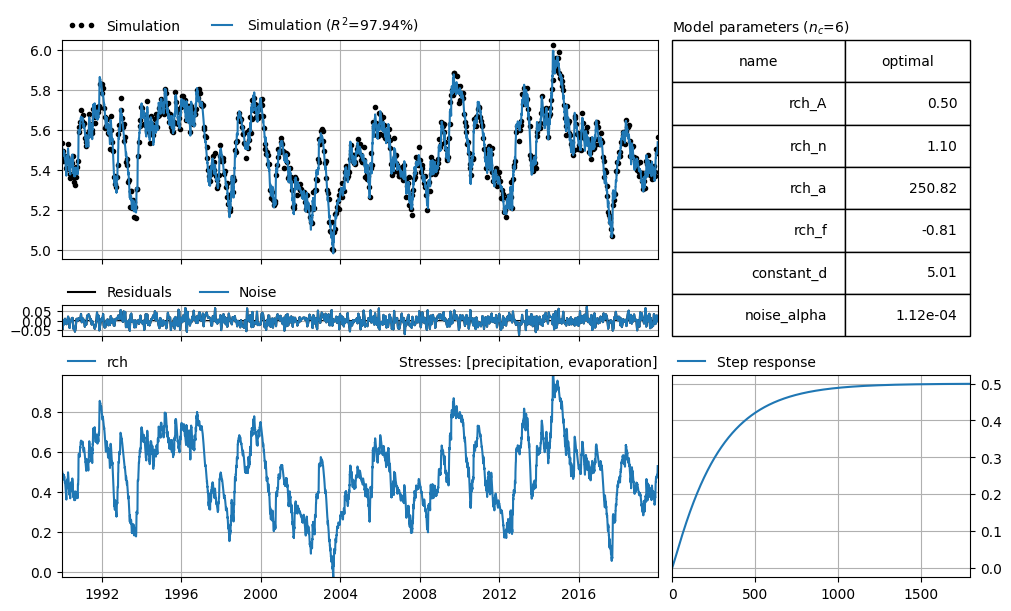

In [5]:
ml_ls = get_model(head)
ml_ls.solve()
axd = ml_ls.plots.results_mosaic()

### RML with finite difference jacobian

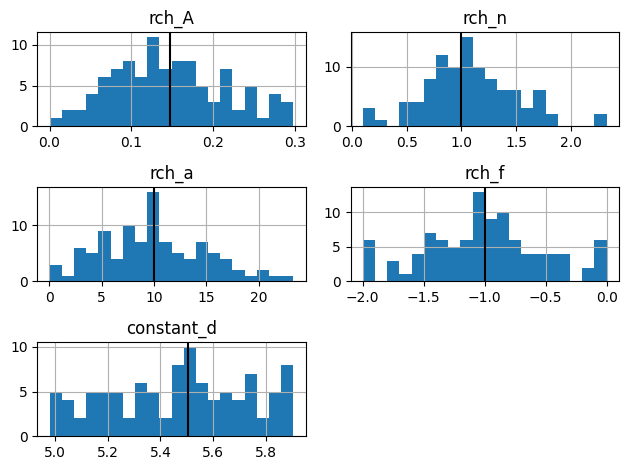

In [6]:
# test finite difference jacobian
ml_rml = get_model(head)
ml_rml.del_noisemodel()
ml_rml.set_parameter(
    "constant_d",
    pmin=ml_rml.parameters.at["constant_d", "initial"]
    - 3 * ml_rml.observations().std(),
    pmax=ml_rml.parameters.at["constant_d", "initial"]
    + 3 * ml_rml.observations().std(),
)

solver = RandomizedMaximumLikelihoodSolver(
    num_reals=100,
    jacobian_method="3-point",
)
ml_rml.add_solver(solver)
solver.initialize(standard_deviation=noise_std, method="norm")  # method="truncnorm"
axes = solver.parameter_ensemble.hist(bins=20)
for ax in axes.ravel():
    title = ax.get_title()
    if title != "":
        ax.axvline(ml_rml.parameters.at[title, "initial"], color="k")
plt.tight_layout()

In [7]:
ml_rml.solve(solver=solver, report=True)

RML looping over realizations: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


Fit report synthetic_model                      Fit Statistics
nfev    100                    EVP                       97.94
nobs    783                    R2                         0.98
noise   False                  RMSE                       0.03
tmin    1990-01-02 00:00:00    AICc                   -5762.22
tmax    2019-12-24 00:00:00    BIC                    -5738.98
freq    D                      Obj                         nan
warmup  3650 days 00:00:00     ___                            
solver  RandomizedMaximumLikelihoodSolverInterp.                      No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.499872   0.146585  True
rch_n         1.098129   1.000000  True
rch_a       250.819485  10.000000  True
rch_f        -0.807632  -1.000000  True
constant_d    5.008214   5.505771  True


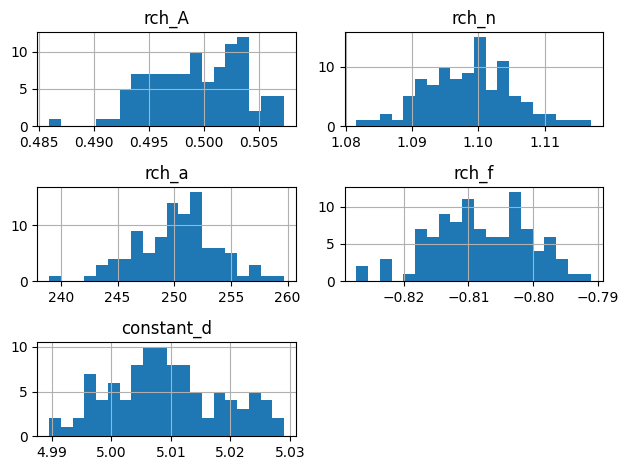

In [8]:
ml_rml.solver.parameter_ensemble.hist(bins=20)
plt.tight_layout()

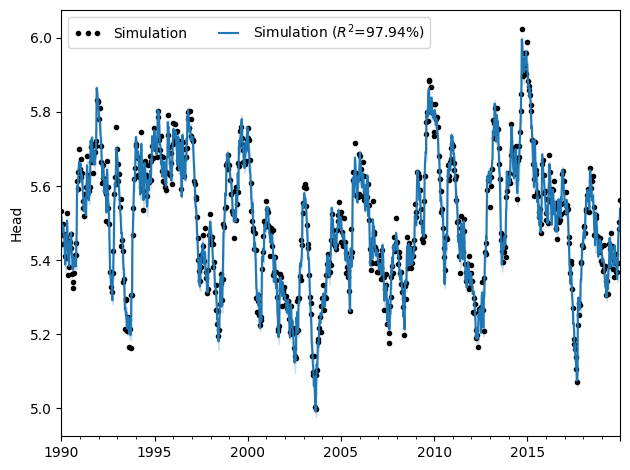

In [9]:
ax = ml_rml.plot()
ax.fill_between(
    ml_rml.solver.simulation_ensemble.index,
    ml_rml.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=0.2,
    color="C0",
)

### RML with emperical jacobian

In [10]:
# test emperical jacobian
ml_rml_em = get_model(head)
ml_rml_em.del_noisemodel()
ml_rml_em.set_parameter(
    "constant_d",
    pmin=ml_rml_em.parameters.at["constant_d", "initial"]
    - 3 * ml_rml_em.observations().std(),
    pmax=ml_rml_em.parameters.at["constant_d", "initial"]
    + 3 * ml_rml_em.observations().std(),
)

solver = RandomizedMaximumLikelihoodSolver(
    num_reals=100, jacobian_method="emperical", noptmax=25
)
ml_rml_em.add_solver(solver)
solver.initialize(standard_deviation=noise_std, method="norm")
ml_rml_em.solve(solver=solver, report=True)

RML looping over noptmax: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]

Fit report synthetic_model                      Fit Statistics
nfev    25                     EVP                       70.27
nobs    783                    R2                         0.70
noise   False                  RMSE                       0.10
tmin    1990-01-02 00:00:00    AICc                   -3670.15
tmax    2019-12-24 00:00:00    BIC                    -3646.91
freq    D                      Obj                         nan
warmup  3650 days 00:00:00     ___                            
solver  RandomizedMaximumLikelihoodSolverInterp.                      No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.352761   0.146585  True
rch_n         0.927464   1.000000  True
rch_a       450.475329  10.000000  True
rch_f        -2.000000  -1.000000  True
constant_d    5.981021   5.505771  True

Warnings! (1)
Parameter 'rch_f' on lower bound: -2.00e+00


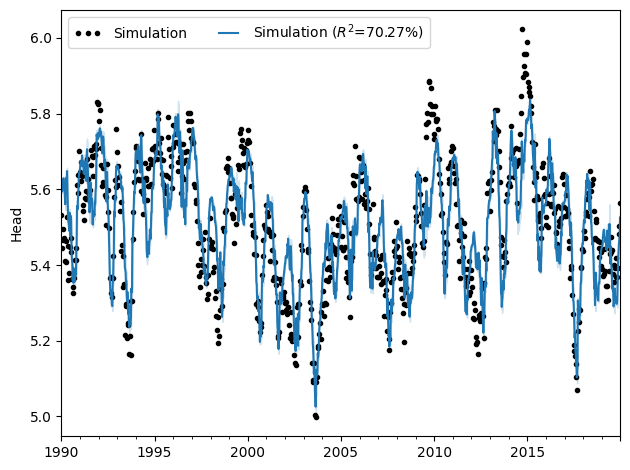

In [11]:
ax = ml_rml_em.plot()
ax.fill_between(
    ml_rml_em.solver.simulation_ensemble.index,
    ml_rml_em.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml_em.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=0.2,
    color="C0",
)

## Compare CI

In [12]:
ls_ci = pd.DataFrame(
    [
        ml_ls.parameters["optimal"] - 1.96 * ml_ls.parameters["stderr"],
        ml_ls.parameters["optimal"] + 1.96 * ml_ls.parameters["stderr"],
    ],
    index=[0.025, 0.975],
)
rml_ci = ml_rml.solver.parameter_ensemble.quantile([0.025, 0.975])
rmlem_ci = ml_rml_em.solver.parameter_ensemble.quantile([0.025, 0.975])
df = pd.concat([ls_ci, rml_ci, rmlem_ci], keys=["LS", "RML", "RML-EM"], axis=1).T
df.swaplevel(0, 1).sort_index()

0.025       0.975
constant_d  LS        4.990119    5.026307
            RML       4.993271    5.025714
            RML-EM    5.969857    5.989329
noise_alpha LS        0.000112    0.000112
rch_A       LS        0.491566    0.508178
            RML       0.491931    0.506780
            RML-EM    0.344406    0.358901
rch_a       LS      242.481693  259.157945
            RML     243.479869  256.948973
            RML-EM  430.604102  463.763341
rch_f       LS       -0.822956   -0.792308
            RML      -0.823521   -0.795637
            RML-EM   -2.000000   -2.000000
rch_n       LS        1.082902    1.113356
            RML       1.085830    1.112028
            RML-EM    0.915651    0.937558

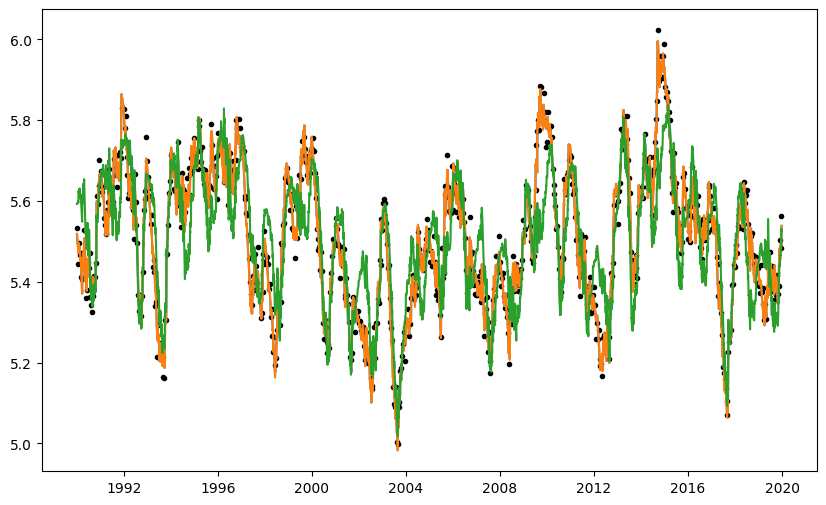

In [13]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    ml_ls.observations(), label="Observations", color="k", linestyle="None", marker="."
)
ax.plot(ml_ls.simulate(), color="C0")
ax.plot(ml_rml.simulate(), color="C1")
ax.plot(ml_rml_em.simulate(), color="C2")